In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt


from models.BetaVAE import Lit_BetaVAE
from models.MKMMD_VAE import Lit_MKMMD_VAE
from models.InfoVAE import Lit_InfoVAE
from helpers.PhotonsDataModule import PhotonsDataModule

In [28]:
LOAD_CHECKPOINT_PATH='/home/jakmic/Projekty/dose3d-phsp/AE_VAE/Lightning_Autoencoders/results/InfoVAE/version_5/checkpoints/last.ckpt'#'/home/jakmic/Projekty/dose3d-phsp/AE_VAE/Lightning_Autoencoders/results/MKMMD_VAE/version_7/last.ckpt'
DATA_PATH='/data1/dose-3d-generative/data/training-data/PHSPs_without_VR/Filtered_E5.6_s0.0.npy'
BATCH_SIZE=400000
NUM_WORKERS=0
TEST_FRACTION=0.0
VALIDATION_FRACTION = 0.4
SHUFFLE_TRAIN=False
RANDOM_SEED=123

In [ ]:
# Remember to change model !!!
model=Lit_InfoVAE.load_from_checkpoint(LOAD_CHECKPOINT_PATH)

In [29]:
dm=PhotonsDataModule(data_path=DATA_PATH,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,test_fraction=TEST_FRACTION,validation_fraction=VALIDATION_FRACTION,shuffle_train=SHUFFLE_TRAIN,random_seed=RANDOM_SEED)
dm.setup()

In [30]:
orginal_photons=np.empty((0,6))
decoded=np.empty((0,6))
generated=np.empty((0,6))

model.eval()
with torch.no_grad():
    for photon_batch in dm.val_dataloader():
        # Generate noise batch from normal distribution
        noise_batch=torch.randn(size=(photon_batch.size(0),3))

        # Encode+Decode orginal photons from val_loader
        _, _, _, decoded_batch = model(photon_batch)
        # Decode noise batch
        generated_batch = model.decoder(noise_batch)

        # Detach batches to numpy arrays
        photon_batch=photon_batch.cpu().detach().numpy()
        decoded_batch=decoded_batch.cpu().detach().numpy()
        generated_batch=generated_batch.cpu().detach().numpy()

        # Standarizer inverse transform
        photon_batch=dm.stdcs.inverse_transform(photon_batch)
        decoded_batch=dm.stdcs.inverse_transform(decoded_batch)
        generated_batch=dm.stdcs.inverse_transform(generated_batch)

        # Prepare numpy arrays
        orginal_photons = np.append(orginal_photons,photon_batch, axis=0)
        decoded = np.append(decoded, decoded_batch,axis=0)
        generated = np.append(generated, generated_batch,axis=0)

        print(decoded.shape)

(400000, 6)
(800000, 6)
(1200000, 6)
(1600000, 6)
(2000000, 6)
(2400000, 6)
(2800000, 6)
(3200000, 6)
(3600000, 6)
(4000000, 6)
(4400000, 6)
(4800000, 6)
(5087614, 6)


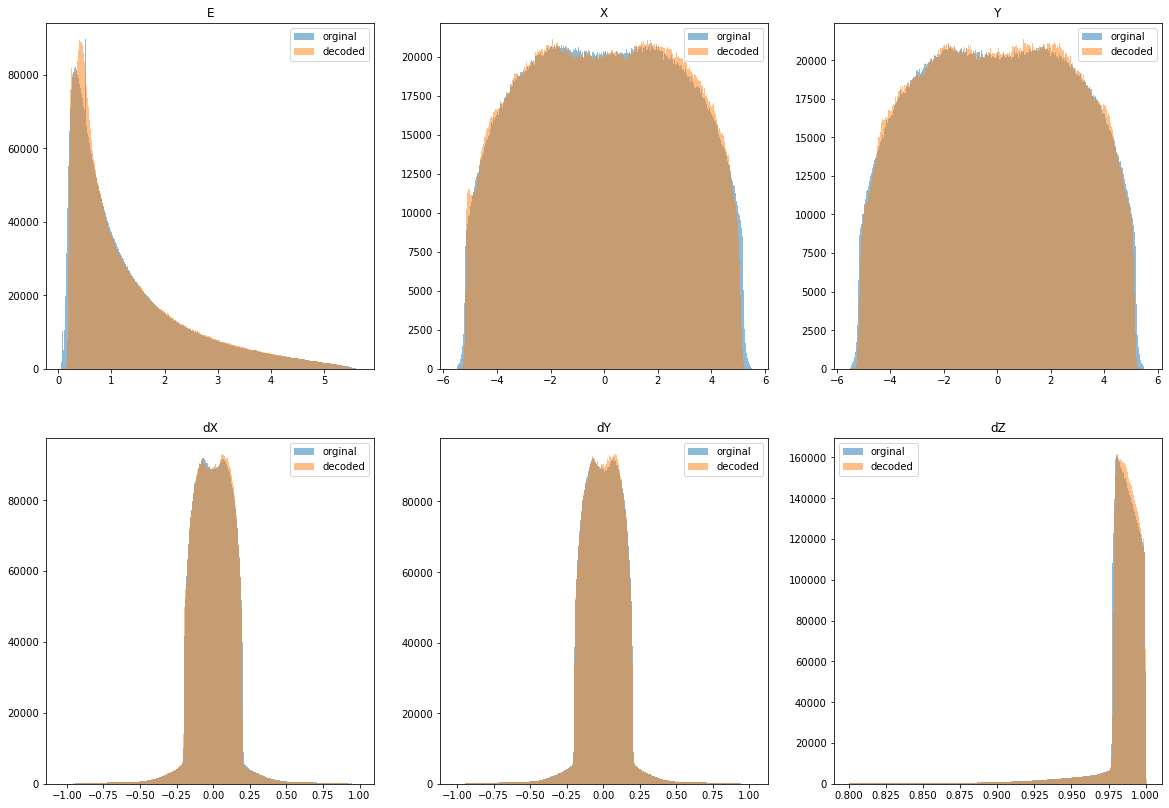

In [31]:
keys = ['E','X', 'Y', 'dX', 'dY', 'dZ']
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)
for i, j in enumerate(keys):
    mi = np.minimum(orginal_photons[:, i].min(), decoded[:, i].min())
    ma = np.maximum(orginal_photons[:, i].max(), decoded[:, i].max())
    if j=='dZ':
        mi=0.8
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal_photons[:, i], bins, alpha=.5, label='orginal')
    axs.flatten()[i].hist(decoded[:, i], bins, alpha=.5, label='decoded')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()

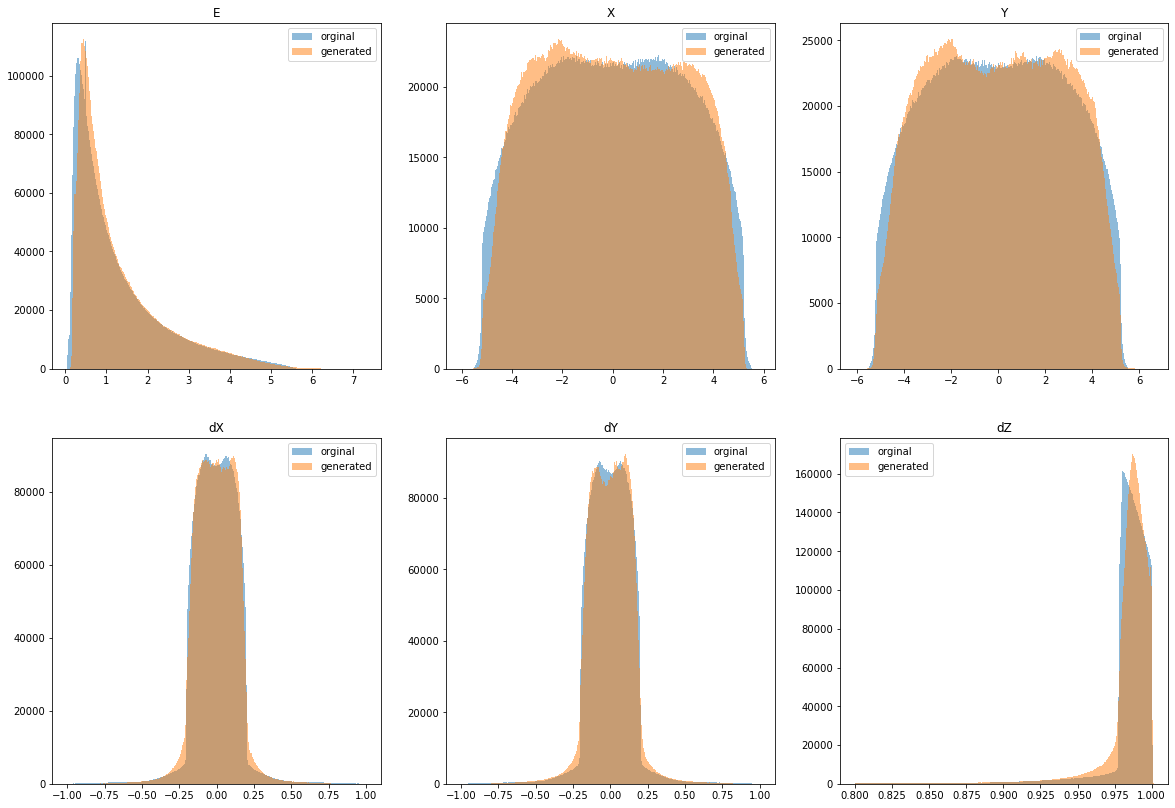

In [32]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)
for i, j in enumerate(keys):
    mi = np.minimum(orginal_photons[:, i].min(), generated[:, i].min())
    ma = np.maximum(orginal_photons[:, i].max(), generated[:, i].max())
    if j=='dZ':
        mi=0.8
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal_photons[:, i], bins, alpha=.5, label='orginal')
    axs.flatten()[i].hist(generated[:, i], bins, alpha=.5, label='generated')
    axs.flatten()[i].set_title(j)
    axs.flatten()[i].legend()